In [2]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

import mapclassify as mc
import math

from handlers import TextLegendHandler
from helper_scripts import utils

# set up a handler for text legends
Legend.update_default_handler_map({str: TextLegendHandler.TextHandler()})

# disable settingwithcopywarning, a false positive in our case
pd.options.mode.chained_assignment = None  # default='warn'

# update default font
plt.rcParams["font.family"] = "Frutiger Light Condensed"

### helper functions

In [57]:
def preprocess_data(data: pd.DataFrame, post: str, party: str) -> pd.DataFrame:
    """
    Preprocesses the data and aggregates it by party and wards
    for the specific post and the specific party

    Args:
        post (str): the post in contention
        party (str): the political party in contention
    """
    preprocessed_data = data[(data["contested_post"] == post)]
    preprocessed_data = preprocessed_data[["party", "palika", "ward", "votes"]]

    preprocessed_data = (
        preprocessed_data.groupby(["party", "palika", "ward"]).sum().reset_index()
    )

    preprocessed_data["% of ward votes"] = (
        preprocessed_data["votes"]
        / preprocessed_data.groupby(["palika", "ward"])["votes"].transform("sum")
        * 100
    )

    preprocessed_data = preprocessed_data[preprocessed_data["party"] == party]

    return preprocessed_data


def prepare_axes(figsize):
    """
    prepares the axes and subplots that are used in the figure
    returns the figure, and a list of axes objects
    """
    fig = plt.figure(figsize=figsize)
    # add axes for main map plots, the party selected, and the other top 3 candidates
    axes = [fig.add_subplot(2, 3, 2)]
    axes.append(fig.add_subplot(2, 3, 3))
    axes.append(fig.add_subplot(2, 3, 5))
    axes.append(fig.add_subplot(2, 3, 6))

    # this plot will show a map of the district, with the map of the region number highlighted
    axes.append(fig.add_subplot(1, 3, 1))

    # set the axes bboxes off
    for ax in axes:
        ax.set_axis_off()

    return fig, axes

### Import raw data

In [58]:
elec_data = pd.read_csv("../../data/election_data/ward_votes_all.csv")
map_data = gpd.read_file("../../data/nepal_map_data/nepal-wards.topojson")

# only selecting the required columns
ward_constituency_map_data = pd.read_csv(
    "../../data/nepal_map_data/ktm-constituencies.csv"
)[["palika", "ward", "representative_constituency", "provincial_constituency"]]

### Transform the data to select Kathmandu and correct constituencies for Kathmandu in elec_data

In [59]:
district = "kathmandu"

wards_data_ktm = map_data.query(
    f'DISTRICT.str.contains("{district.upper()}")', engine="python"
)
elec_data_ktm = elec_data.query(
    f'district.str.contains("{district.lower()}")', engine="python"
)

constituency_clean_data = ward_constituency_map_data.fillna(0)
constituency_clean_data["ward"] = pd.to_numeric(
    constituency_clean_data["ward"], downcast="integer"
)
merged_elec_data_ktm = pd.merge(
    elec_data_ktm,
    constituency_clean_data,
    how="inner",
    on=["ward", "palika"],
    suffixes=("_l", "_r"),
)
clean_elec_data_ktm = merged_elec_data_ktm[
    merged_elec_data_ktm["provincial_constituency_r"] != 0
]

### Prepping for the plotting

In [60]:
regions = sorted(clean_elec_data_ktm["representative_constituency_r"].unique())
norm = matplotlib.colors.Normalize(vmin=0, vmax=70)

# use this map after all parties have been populated
parties_map = {
    "Nepali Congress": "Greens",
    "CPN-UML": "Oranges",
    "Maoist Centre": "Reds",
    "Janata Samajwadi Party": "Purples",
}

# for the mean time, when all parties have not been populated
parties_colors = ["Greens", "Oranges", "Reds", "Purples"]

### The actual visualization

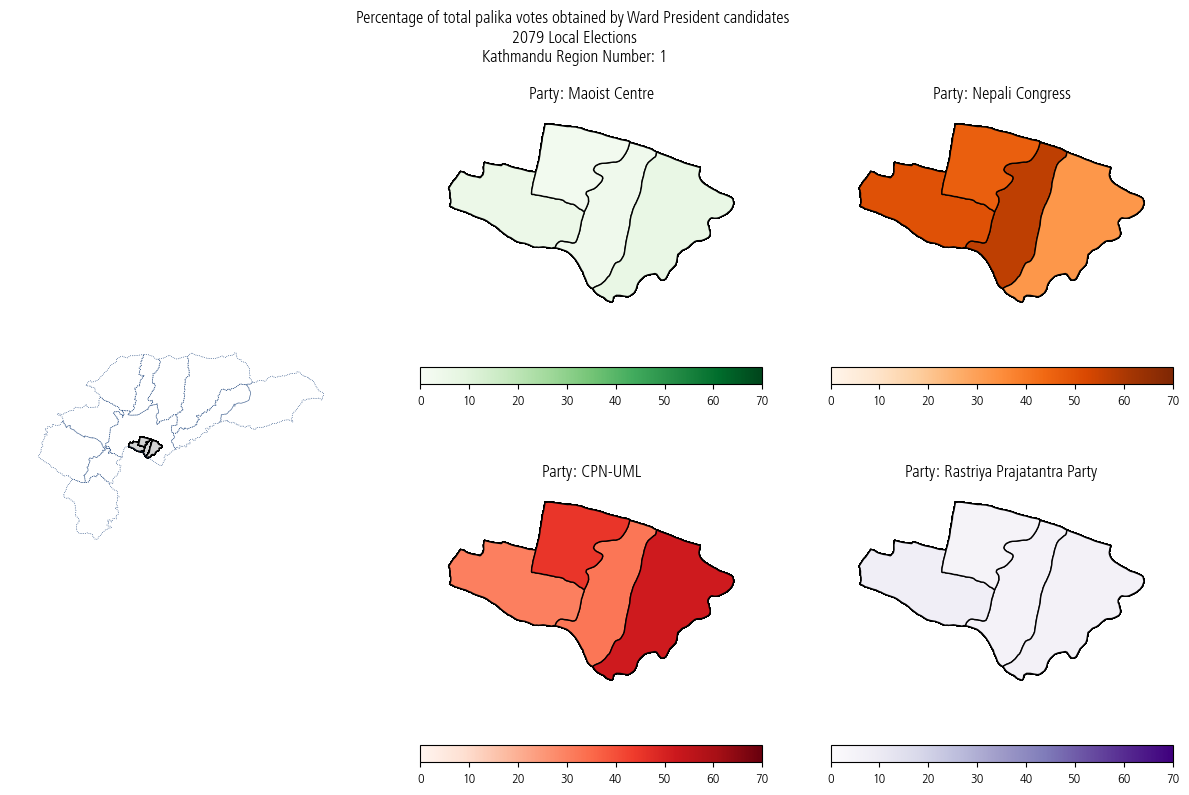

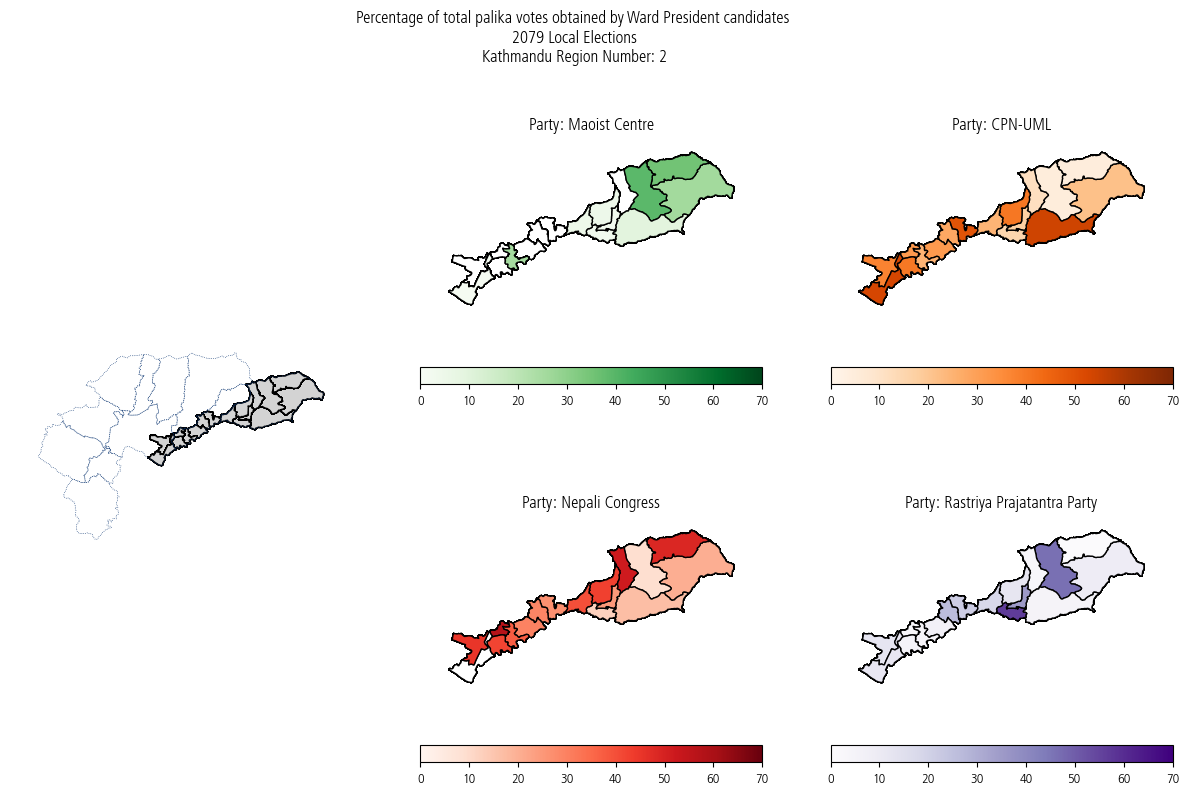

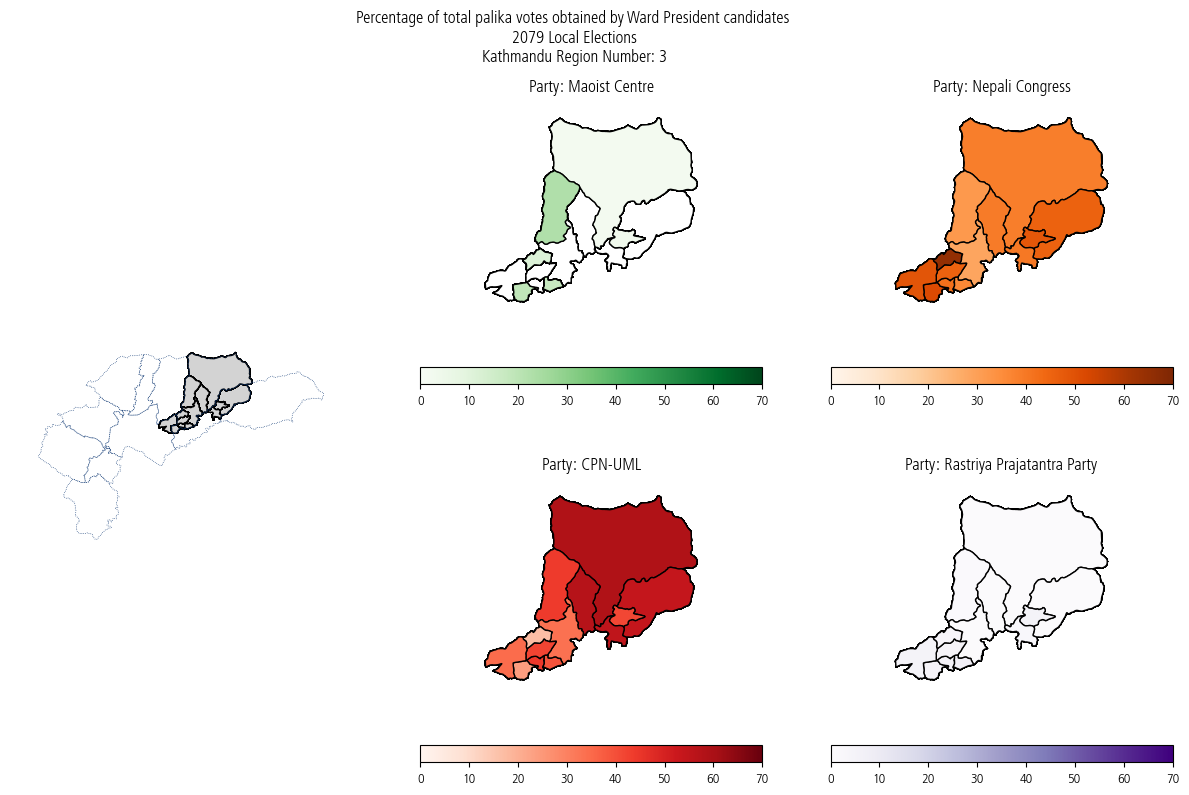

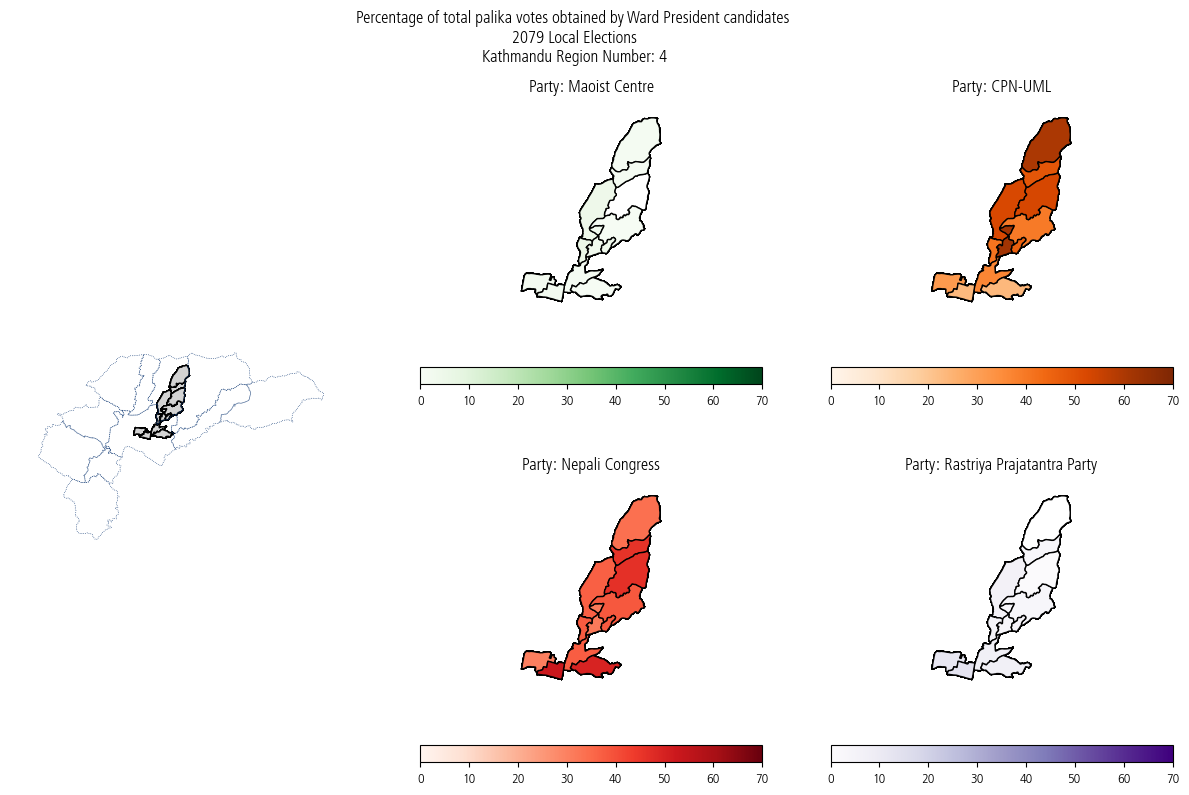

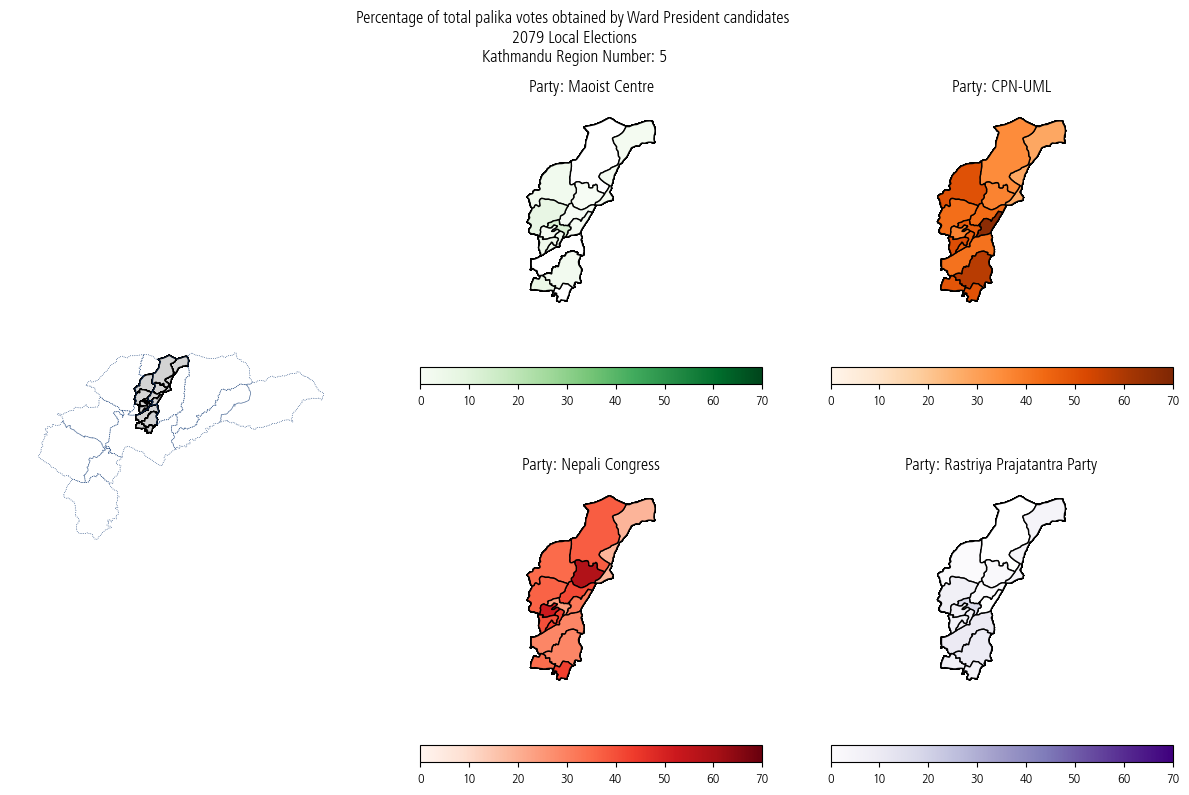

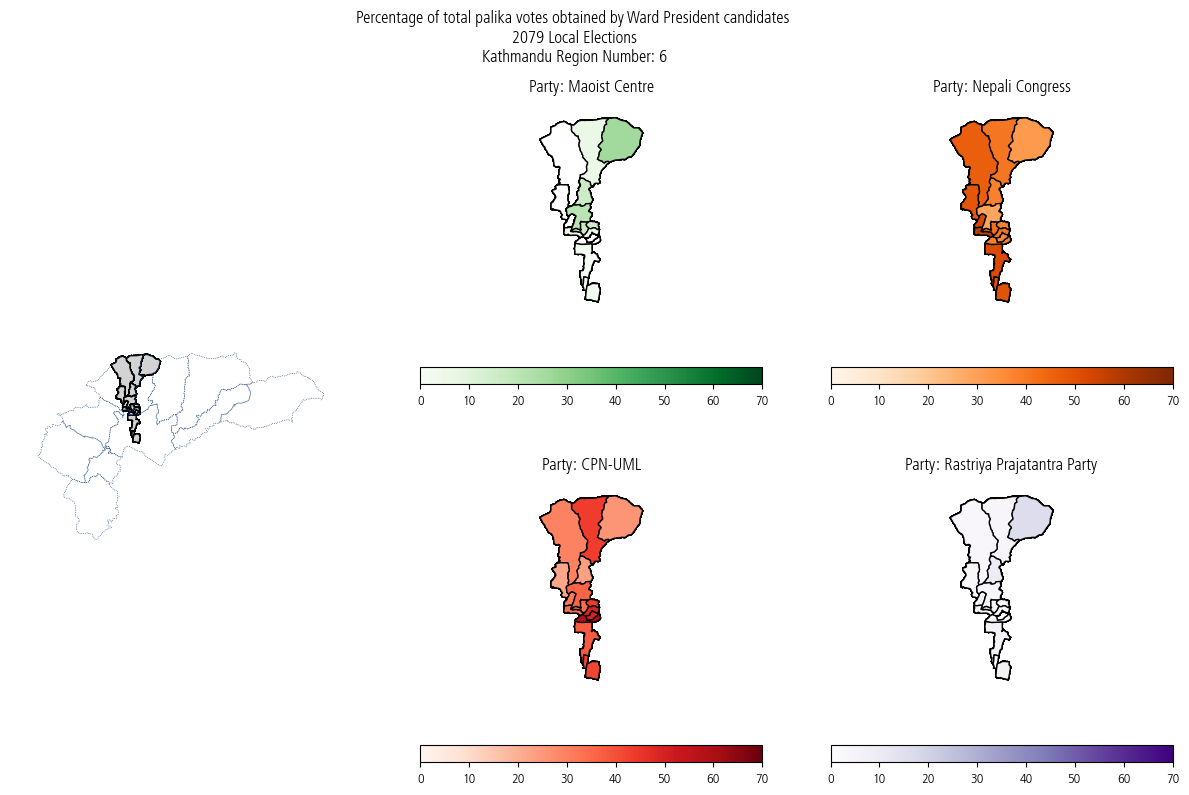

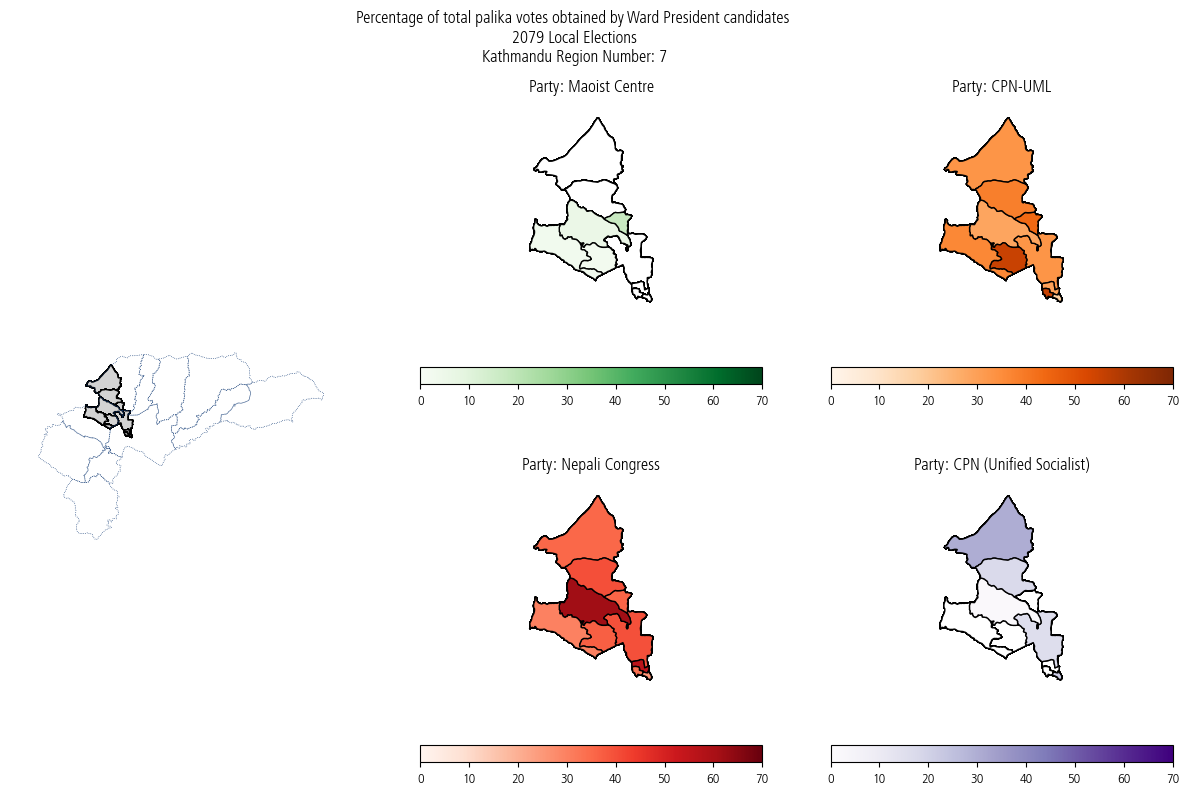

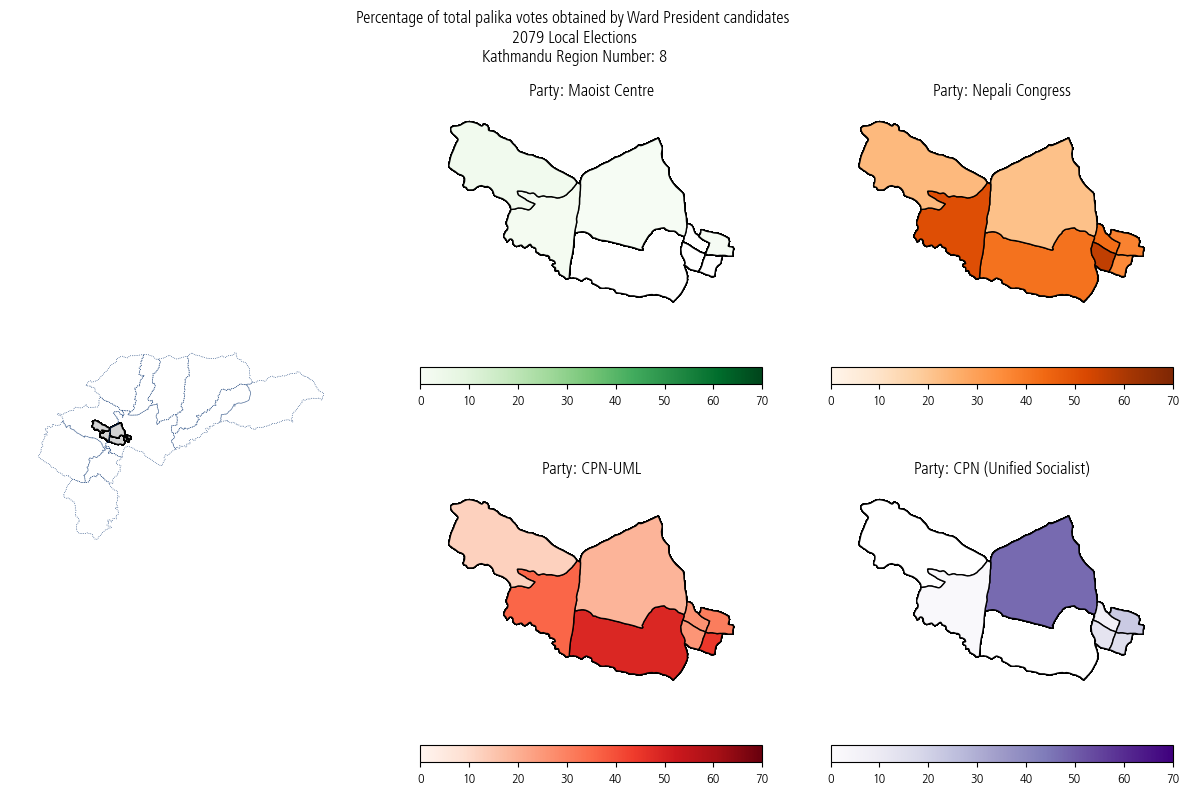

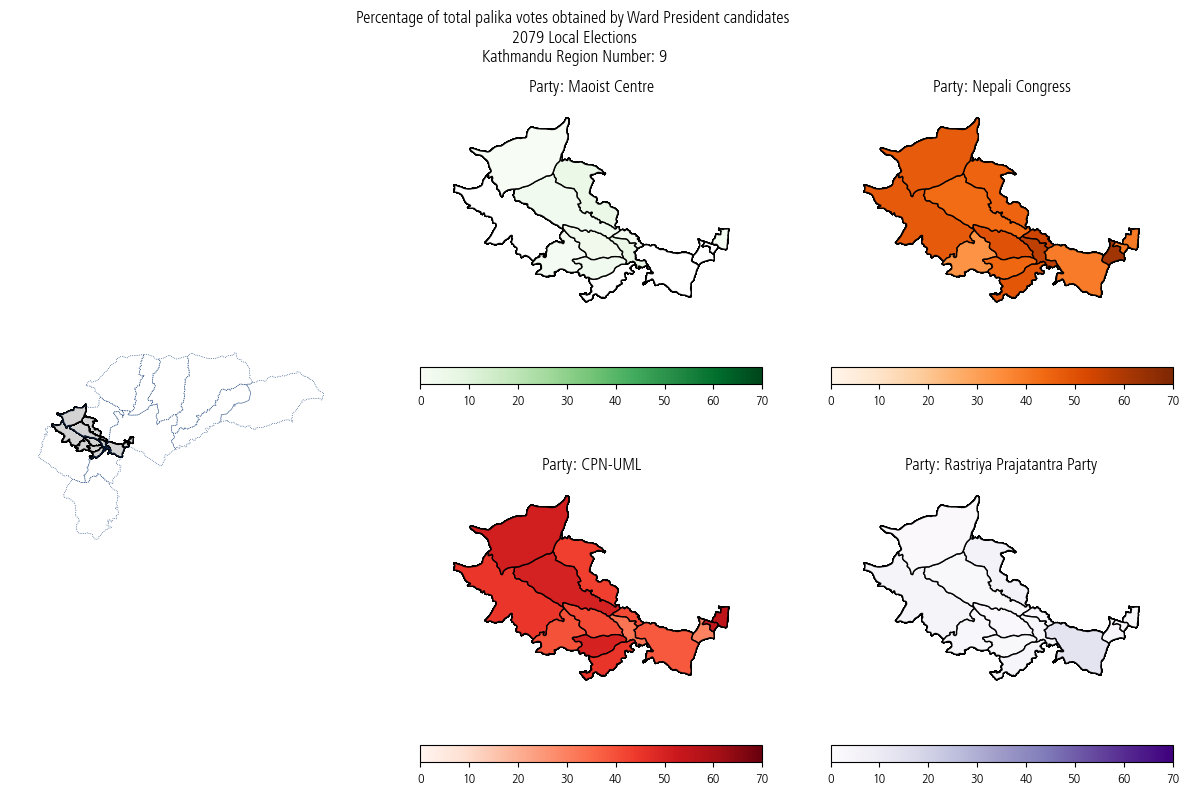

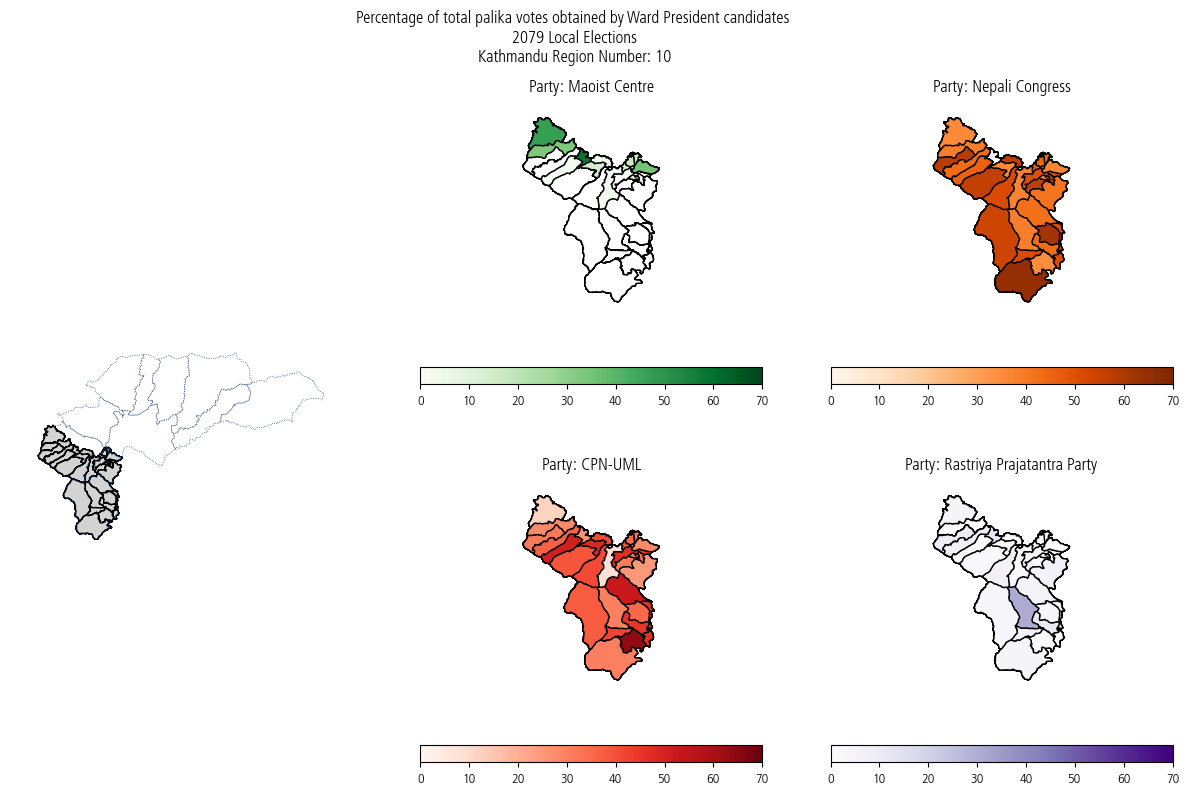

In [63]:
selected_party = "Maoist Centre"

for region in regions:
    regional_elec_data_ktm = clean_elec_data_ktm[
        clean_elec_data_ktm["representative_constituency_r"] == region
    ]
    regional_elec_data_ktm["palika"] = regional_elec_data_ktm.copy()[
        "palika"
    ].transform(lambda x: utils.transform_to_capitalized_case(x, "-"))

    # a non colored map of the selected region, only the ward borders
    skeleton_constituency_data_ktm = gpd.GeoDataFrame(
        regional_elec_data_ktm.merge(
            wards_data_ktm,
            how="inner",
            left_on=["palika", "ward"],
            right_on=["PALIKA", "WARD"],
        )
    )

    fig, axes = prepare_axes((15, 9))

    # select the top 4 parties in that constituency
    top_parties_constituency = list(
        regional_elec_data_ktm.groupby(["party"])
        .sum("votes")
        .reset_index()
        .nlargest(4, ["votes"])
        .sort_values("votes", ascending=False)["party"]
    )

    if selected_party in list(top_parties_constituency):
        top_parties_constituency.remove(selected_party)
        alternatives = top_parties_constituency
    else:
        alternatives = top_parties_constituency[:3]
    selected_parties = [selected_party, *alternatives]

    # to use when all parties cmaps have been populated
    # selected_parties_cmap = {party:parties_map[k] for party in selected_parties if party in parties_map}

    # for the meantime when all cmaps have not been populated
    selected_parties_cmap = {}
    for idx, party in enumerate(selected_parties):
        selected_parties_cmap[party] = parties_colors[idx]

    # plotting the Kathmandu district wireframe, with the representative constituency highlighted
    gplt.polyplot(
        skeleton_constituency_data_ktm,
        facecolor="lightgray",
        ax=axes[-1],
    )

    gplt.polyplot(
        wards_data_ktm.copy().dissolve(by=["PALIKA"]),
        ax=axes[-1],
        linestyle=":",
        edgecolor="#083370",
        linewidth=0.5,
    )

    for idx, (party, pallete) in enumerate(selected_parties_cmap.items()):
        final_data = gpd.GeoDataFrame(
            preprocess_data(regional_elec_data_ktm, "Ward President", party).merge(
                wards_data_ktm,
                how="inner",
                left_on=["palika", "ward"],
                right_on=["PALIKA", "WARD"],
            )
        )

        cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=pallete).cmap

        gplt.choropleth(
            final_data,
            hue="% of ward votes",
            cmap=cmap,
            norm=norm,
            legend=True,
            legend_kwargs={"orientation": "horizontal"},
            ax=axes[idx],
        )

        # since 0 vote regions are omitted by the choropleth map, we draw a white backgrounded polygon map
        gplt.polyplot(
            skeleton_constituency_data_ktm,
            facecolor="white",
            ax=axes[idx],
        )
        axes[idx].set_title(f"Party: {party}")
    fig.suptitle(
        f"Percentage of total palika votes obtained by Ward President candidates\n 2079 Local Elections\n {district.capitalize()} Region Number: {region}"
    )
    plt.show()

In [45]:
selected = "Ra Pra Pa"
alternatives = []

top_parties = list(
    clean_elec_data_ktm[clean_elec_data_ktm["representative_constituency_r"] == 2]
    .groupby(["party"])
    .sum("votes")
    .reset_index()
    .nlargest(4, ["votes"])
    .sort_values("votes")["party"]
)
print(top_parties)
if selected in list(top_parties):
    top_parties.remove(selected)
    alternatives = top_parties
else:
    alternatives = top_parties[:3]

['CPN (Unified Socialist)', 'Rastriya Prajatantra Party', 'Nepali Congress', 'CPN-UML']
